# Бонусное домашнее задание

## Part 0

В данном домашнем задании вам предстоит реализовать СLIP -- self-supervision модель которая выучивает зависимости между картинками и текстов в едином векторном пространстве. Для выполнения этого домашнего задания вам понадобится GPU и несколько дополнительных библиотек. Автор рекомендует делать все исключительно в Kaggle. 


[Ссылка на датасет](https://www.kaggle.com/datasets/keenwarrior/small-flicker-data-for-image-captioning)

[Ссылка на статью](https://openai.com/research/clip)

Задания в ноутбуке будут во многом опираться на статью, поэтому рекомендуется ее прочитать перед выполнением.

In [1]:
%pip install timm
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
import timm
import kagglehub

PATH_TO_IMAGES = r"C:\Users\1\vscode-projects\dl-hse\hw4\flickr1k\images"

## Part 1 (8 баллов)

Для начала нам нужно реализовать составляющие модели: Кодировщик картинок, текста и проектор на какое-то маломерное пространство. В папке с заданием есть соответствующие файлы, заполните пропуски в них опираясь на docstring-и.

Разбалловка следующая: 

Правильно реализованные кодировщики: 2 балла.

Правильно реализованный проектор: 2 балла.

Правильно реализованный класс СLIP: 4 балла.

In [4]:

from CLIPDataset import CLIPDataset
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from ImageEncoder import ImageEncoder
from ProjectionHead import ProjectionHead
from TextEncoder import TextEncoder
import torch.nn.functional as F


In [5]:
class CLIP(nn.Module):
    def __init__(self, image_embedding=2048, text_embedding=768, temp =1.0):
        super().__init__()
        self.image_encoder = ImageEncoder(model_name="resnet50", pretrained=True, trainable=False)
        self.text_encoder = TextEncoder(model_name="distilbert-base-uncased", pretrained=True, trainable=False)
        self.image_projections = ProjectionHead(embedding_dim=image_embedding, projection_dim=256, dropout=0.1)
        self.text_projections = ProjectionHead(embedding_dim=text_embedding, projection_dim=256, dropout=0.1)
        self.temp = temp
    def forward(self, batch):
        """
        :batch: dict of images and text
        Here is what you should do:
        1) extract image and text features from batch
        2) project features into projection space (small latent space)
        3) compute cosine similarity with temperature this will be your logits
        4) compute "true" logits (eg. cosine similarity between images and images, text and text)
        5) create targets by averaging similarities from step above (do not forget about temperature)
        6) compute mean loss (see paper)
        7) return loss

        Overall: read paper.
        ПА ПАРЯДКУ 
        """
        # 1)
        image_features = self.image_encoder(batch["image"])  # [N, image_embedding]
        text_features = self.text_encoder(batch['input_ids'], batch['attention_mask'])  # [N, text_embedding]

        # 2) 
        image_proj = self.image_projections(image_features)  # [N, 256]
        text_proj = self.text_projections(text_features)      # [N, 256]

        image_norm = image_proj / image_proj.norm(dim=1, keepdim=True)
        text_norm = text_proj / text_proj.norm(dim=1, keepdim=True)

        # 3) 
        logits = (image_norm @ text_norm.T) / self.temp  # [N, N]

        # 4) 
        batch_size = logits.shape[0]
        targets = torch.arange(batch_size, device=logits.device)

        # 5) 
        loss_i2t = F.cross_entropy(logits, targets, reduction="mean")
        loss_t2i = F.cross_entropy(logits.T, targets, reduction="mean")
        loss = (loss_i2t + loss_t2i) / 2
        return loss
        

def CE(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    return loss   

# Part 2. (0 Баллов)

Здесь вам нужно вписать правильный путь до csv файла на своей машине и запустить код.

In [43]:
def make_train_valid_dfs():
    dataframe = pd.read_csv("C:\\Users\\1\\vscode-projects\\dl-hse\\hw4\\flickr1k\\captions.csv")
    dataframe["id"] = np.array(list(dataframe.index))
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [44]:
def build_loaders(dataframe, tokenizer, mode):
    dataset = CLIPDataset(
        PATH_TO_IMAGES,
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer
    )
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        num_workers=1,
        shuffle=True if mode == "train" else False,
    )
    return dataloader, dataset

In [45]:
class AvgMeter:
    def __init__(self, name="CrossEntropyLoss"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
    def __format__(self, formatspec):
        text = f"{self.name}: {format(self.avg, formatspec)}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [46]:
def train(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

@torch.no_grad()
def validate(model, validation_loader):
    loss_meter = AvgMeter()
    for batch in tqdm(validation_loader, desc="Validating", total=len(validation_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

## Part 3. (2 балла)

За вас написан минимальный код для обучения, если он запускается и модель учится, то за этот пункт вы получите 0.5 балла. Чтобы получить полный балл за задание вам нужно будет провести несколько экспериментов и поподбирать гиперпараметры. Можно начать со статьи.

Я попробовал добавить adam с изменением весом + добавил разминку (вармап картак ксго) + 20 эпох  и какой то косинус расписание. вышел на финалку такую 

Epoch: 19,
Train loss: CrossEntropyLoss: 2.807
Validation loss: CrossEntropyLoss: 2.819 

вот кодик


    import itertools
    import torch.optim as optim
    from torch.optim.lr_scheduler import LambdaLR
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCH = 20
    def procedure():
        train_df, validation_df = make_train_valid_dfs()
        tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
        val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")
        model = CLIP().to(device)
        params = [{"params": model.image_encoder.parameters()}, 
                {"params" : model.text_encoder.parameters()},
                {"params" : itertools.chain(model.image_projections.parameters(),
                                            model.text_projections.parameters())}]
        optimizer = optim.AdamW(params, lr=1e-4, weight_decay=1e-4)
        def lr_lambda(epoch):
            warmup_epochs = 8
            if epoch < warmup_epochs:
                return float(epoch + 1) / warmup_epochs
            else:
                return 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (EPOCH - warmup_epochs)))
        
        lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)   
        step="epoch"
        for epoch in range(EPOCH):
            print(f"Epoch: {epoch}. Train and Validation in progress...")
            model.train()
            train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
            model.eval()
            val_loss = validate(model, val_loader)
            
            lr_scheduler.step(val_loss.avg)
            print(f"Epoch: {epoch},", end="\n")
            print(f"Train loss: {train_loss:0.3f}", end="\n")
            print(f"Validation loss: {val_loss:0.3f}")
        return model

Го пробовать другое, я докину кол-во эпох до 30, аугментацию , другой скельдюер 

In [ ]:
import itertools
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 30
train_transforms = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)), # обрезаю картинку до 224x224
    T.RandomHorizontalFlip(), # случайное отражение по горизонтали
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # изменение яркости, контраста, насыщенности и оттенка
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])
def procedure():
    train_df, validation_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
    val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")
    model = CLIP().to(device)
    params = [{"params": model.image_encoder.parameters()}, 
              {"params" : model.text_encoder.parameters()},
              {"params" : itertools.chain(model.image_projections.parameters(),
                                          model.text_projections.parameters())}]
    optimizer = optim.AdamW(params, lr=1e-4, weight_decay=1e-4)
    steps_per_epoch = len(train_loader)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, 
                                                    steps_per_epoch=steps_per_epoch, epochs=EPOCH,
                                                    anneal_strategy='cos', pct_start=0.1)
    step="epoch"
    for epoch in range(EPOCH):
        print(f"Epoch: {epoch}. Train and Validation in progress...")
        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        val_loss = validate(model, val_loader)
        
        lr_scheduler.step(val_loss.avg)
        print(f"Epoch: {epoch},", end="\n")
        print(f"Train loss: {train_loss:0.3f}", end="\n")
        print(f"Validation loss: {val_loss:0.3f}")
    return model

In [50]:
model = procedure()

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0,
Train loss: CrossEntropyLoss: 3.402
Validation loss: CrossEntropyLoss: 3.221
Epoch: 1. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1,
Train loss: CrossEntropyLoss: 3.187
Validation loss: CrossEntropyLoss: 3.079
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2,
Train loss: CrossEntropyLoss: 3.088
Validation loss: CrossEntropyLoss: 3.013
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3,
Train loss: CrossEntropyLoss: 3.029
Validation loss: CrossEntropyLoss: 2.974
Epoch: 4. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4,
Train loss: CrossEntropyLoss: 2.989
Validation loss: CrossEntropyLoss: 2.947
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5,
Train loss: CrossEntropyLoss: 2.961
Validation loss: CrossEntropyLoss: 2.933
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6,
Train loss: CrossEntropyLoss: 2.938
Validation loss: CrossEntropyLoss: 2.912
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7,
Train loss: CrossEntropyLoss: 2.914
Validation loss: CrossEntropyLoss: 2.899
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8,
Train loss: CrossEntropyLoss: 2.900
Validation loss: CrossEntropyLoss: 2.884
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9,
Train loss: CrossEntropyLoss: 2.886
Validation loss: CrossEntropyLoss: 2.874
Epoch: 10. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10,
Train loss: CrossEntropyLoss: 2.876
Validation loss: CrossEntropyLoss: 2.870
Epoch: 11. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11,
Train loss: CrossEntropyLoss: 2.865
Validation loss: CrossEntropyLoss: 2.865
Epoch: 12. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12,
Train loss: CrossEntropyLoss: 2.854
Validation loss: CrossEntropyLoss: 2.855
Epoch: 13. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13,
Train loss: CrossEntropyLoss: 2.852
Validation loss: CrossEntropyLoss: 2.854
Epoch: 14. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14,
Train loss: CrossEntropyLoss: 2.842
Validation loss: CrossEntropyLoss: 2.844
Epoch: 15. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15,
Train loss: CrossEntropyLoss: 2.836
Validation loss: CrossEntropyLoss: 2.842
Epoch: 16. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 16,
Train loss: CrossEntropyLoss: 2.832
Validation loss: CrossEntropyLoss: 2.836
Epoch: 17. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 17,
Train loss: CrossEntropyLoss: 2.824
Validation loss: CrossEntropyLoss: 2.833
Epoch: 18. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 18,
Train loss: CrossEntropyLoss: 2.823
Validation loss: CrossEntropyLoss: 2.830
Epoch: 19. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 19,
Train loss: CrossEntropyLoss: 2.818
Validation loss: CrossEntropyLoss: 2.828
Epoch: 20. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 20,
Train loss: CrossEntropyLoss: 2.812
Validation loss: CrossEntropyLoss: 2.824
Epoch: 21. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 21,
Train loss: CrossEntropyLoss: 2.811
Validation loss: CrossEntropyLoss: 2.819
Epoch: 22. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 22,
Train loss: CrossEntropyLoss: 2.802
Validation loss: CrossEntropyLoss: 2.819
Epoch: 23. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 23,
Train loss: CrossEntropyLoss: 2.801
Validation loss: CrossEntropyLoss: 2.818
Epoch: 24. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 24,
Train loss: CrossEntropyLoss: 2.796
Validation loss: CrossEntropyLoss: 2.818
Epoch: 25. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 25,
Train loss: CrossEntropyLoss: 2.800
Validation loss: CrossEntropyLoss: 2.813
Epoch: 26. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 26,
Train loss: CrossEntropyLoss: 2.795
Validation loss: CrossEntropyLoss: 2.812
Epoch: 27. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 27,
Train loss: CrossEntropyLoss: 2.789
Validation loss: CrossEntropyLoss: 2.811
Epoch: 28. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 28,
Train loss: CrossEntropyLoss: 2.788
Validation loss: CrossEntropyLoss: 2.810
Epoch: 29. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 29,
Train loss: CrossEntropyLoss: 2.791
Validation loss: CrossEntropyLoss: 2.807


Сейчас пришел к такому 

Epoch: 29,
Train loss: CrossEntropyLoss: 2.791
Validation loss: CrossEntropyLoss: 2.807

в целом удольтворительно. я к сожалению не обладаю ресурсами чтобы выдавить что то еще (предлагать хакать кагл не надо), так то можно было поморозить и  разморозить веса, увеличить размер батча и повозиться с гиперпараметрами в сторону усложенения модели.

## Part 4 (0 баллов)

Просто посмотрим на результаты.

In [51]:
@torch.inference_mode()
def get_image_embeddings(valid_df, model):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    valid_loader, _ = build_loaders(valid_df, tokenizer, mode="valid")
    valid_image_embeddings = []
    for batch in tqdm(valid_loader, desc="Getting embeddings", total=len(valid_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        image_features = model.image_encoder(batch["image"].to(device))
        image_embeddings = model.image_projections(image_features)
        valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

In [52]:
import matplotlib.pyplot as plt
@torch.inference_mode()
def find_match(model, image_embeddings, text, image_filenames, num_examples=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_encoded = tokenizer([text])
    batch = {key : torch.tensor(value).to(device) for key, value in text_encoded.items()}
    
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projections(text_features)
    
    norm_image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    norm_text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    
    similarity = norm_text_embeddings @ norm_image_embeddings.T
    
    ans, ans_index = torch.topk(similarity.squeeze(0), num_examples * 5)
    match = [image_filenames[index] for index in ans_index[::5]]
    fig, ax = plt.subplots(int(num_examples/2), int(num_examples/2), figsize= (10, 10))
    for m, a in zip(match, ax.flatten()):
        image = Image.open(f"{PATH_TO_IMAGES}" + f"/{m}")
        image = image.convert("RGB")
        a.imshow(image)
        a.axis("off")
    plt.show()
    

In [53]:
_, valid_df = make_train_valid_dfs()
image_embeddings = get_image_embeddings(valid_df, model)

Getting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

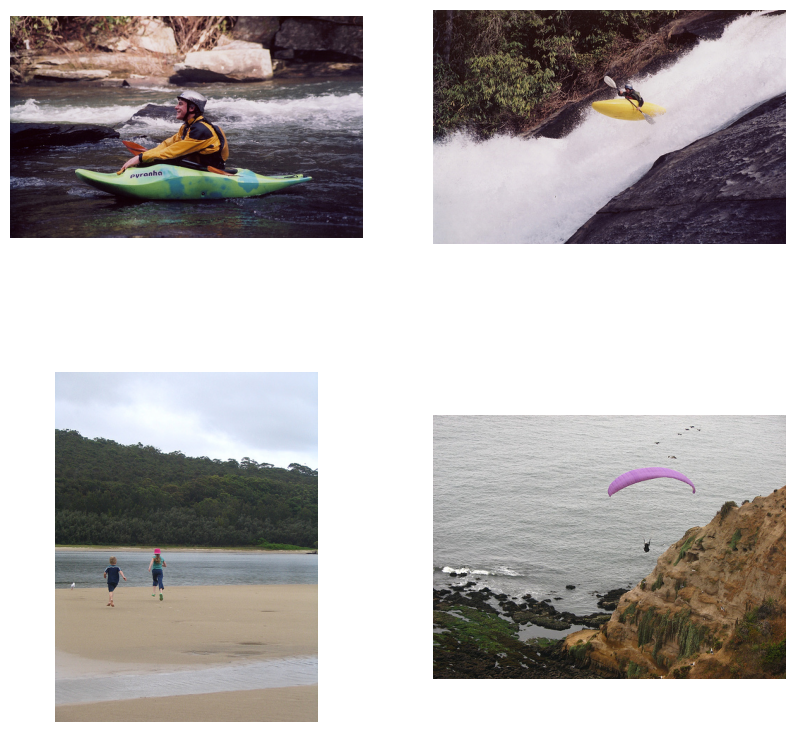

In [57]:
find_match(model, image_embeddings, "sea", valid_df["image"].values)

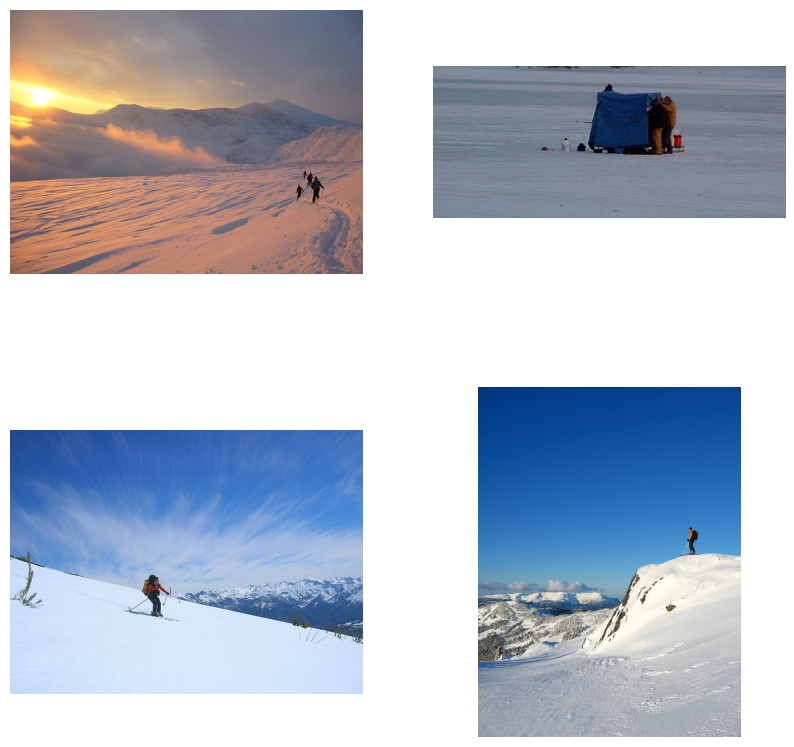

In [58]:
find_match(model, image_embeddings, "snow", valid_df["image"].values)

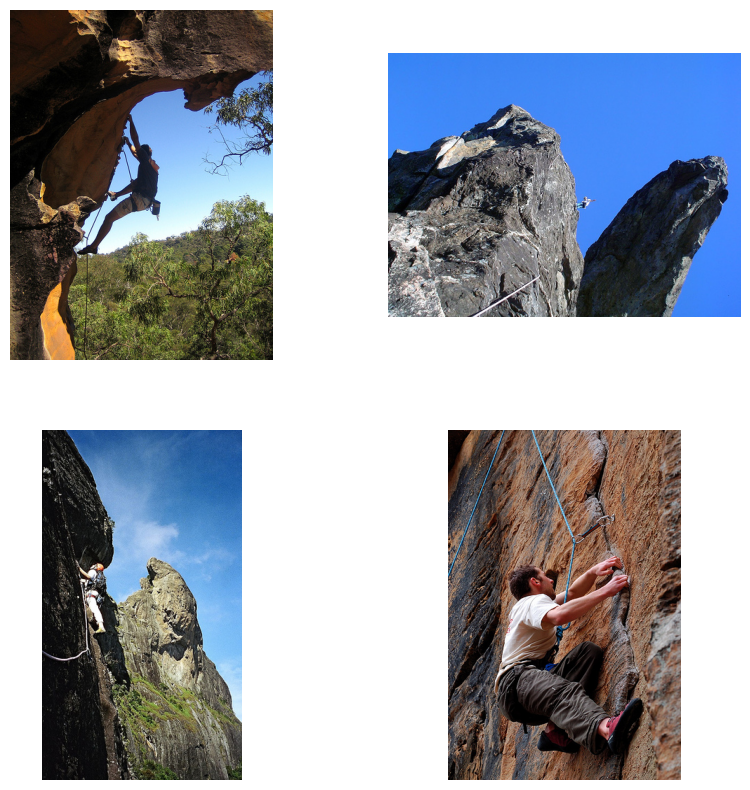

In [59]:
find_match(model, image_embeddings, "rock", valid_df["image"].values)

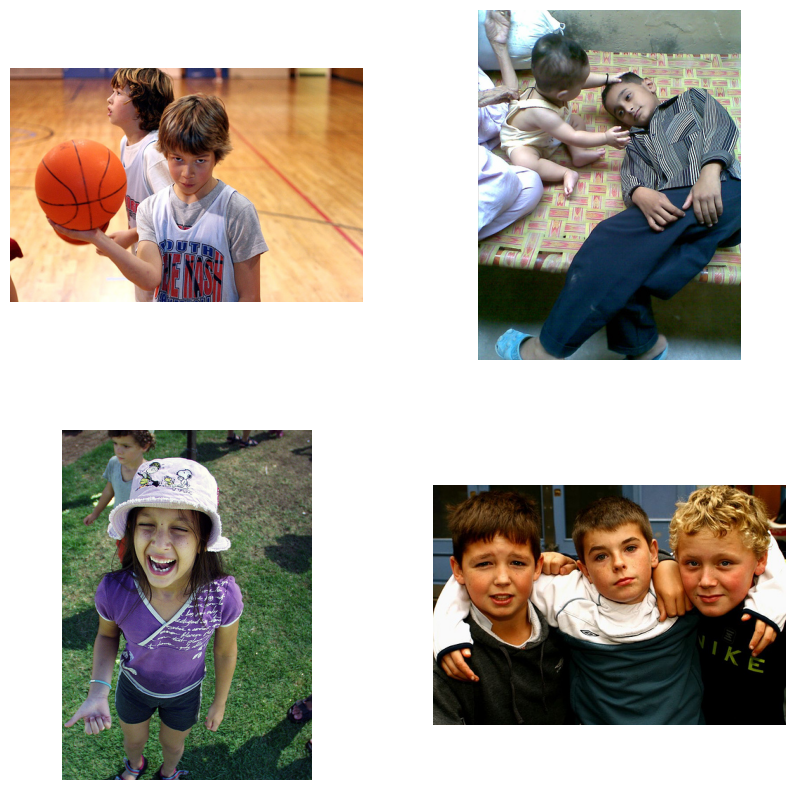

In [66]:
find_match(model, image_embeddings, "kids", valid_df["image"].values)

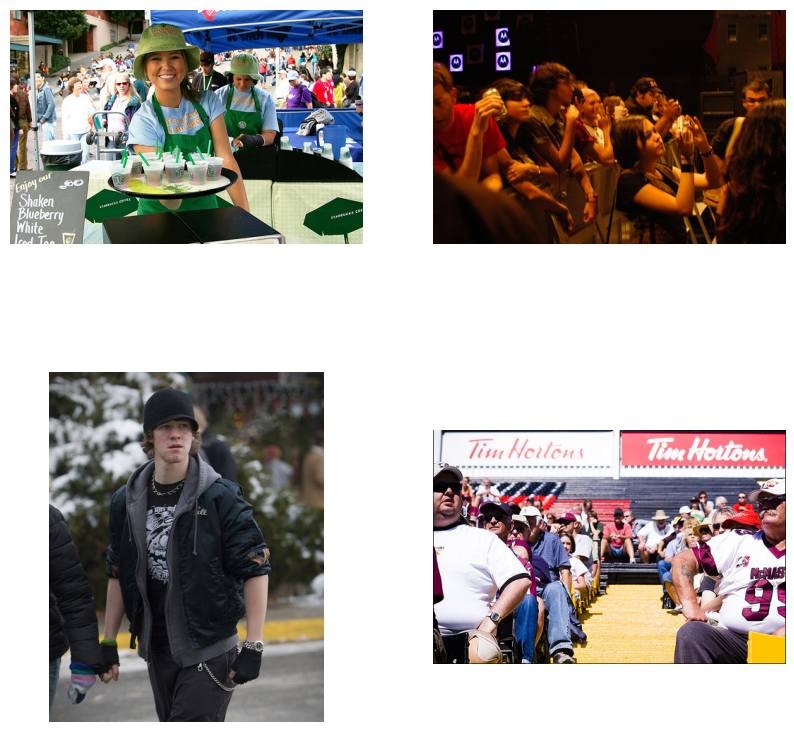

In [67]:
find_match(model, image_embeddings, "adults", valid_df["image"].values)

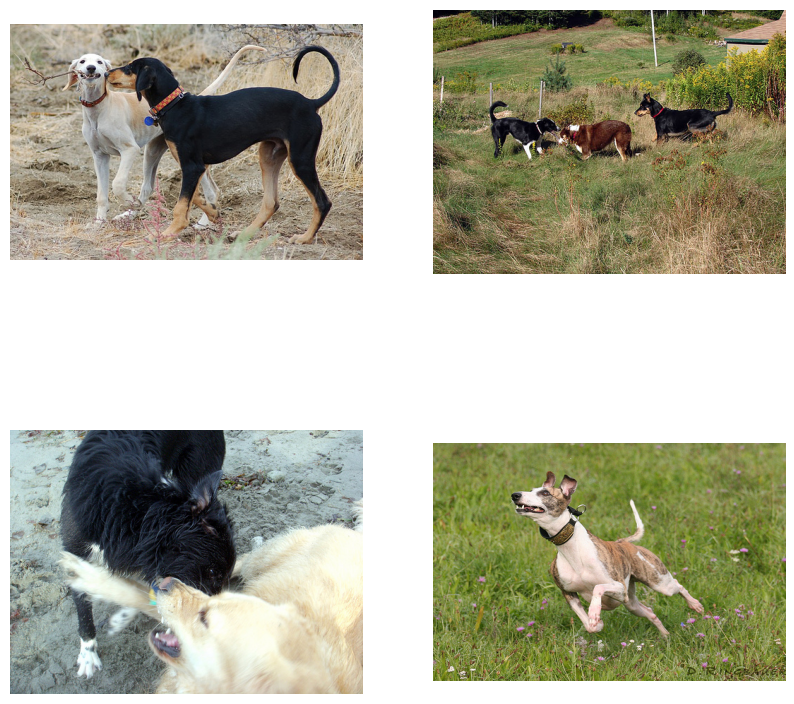

In [75]:
find_match(model, image_embeddings, "dogs", valid_df["image"].values)

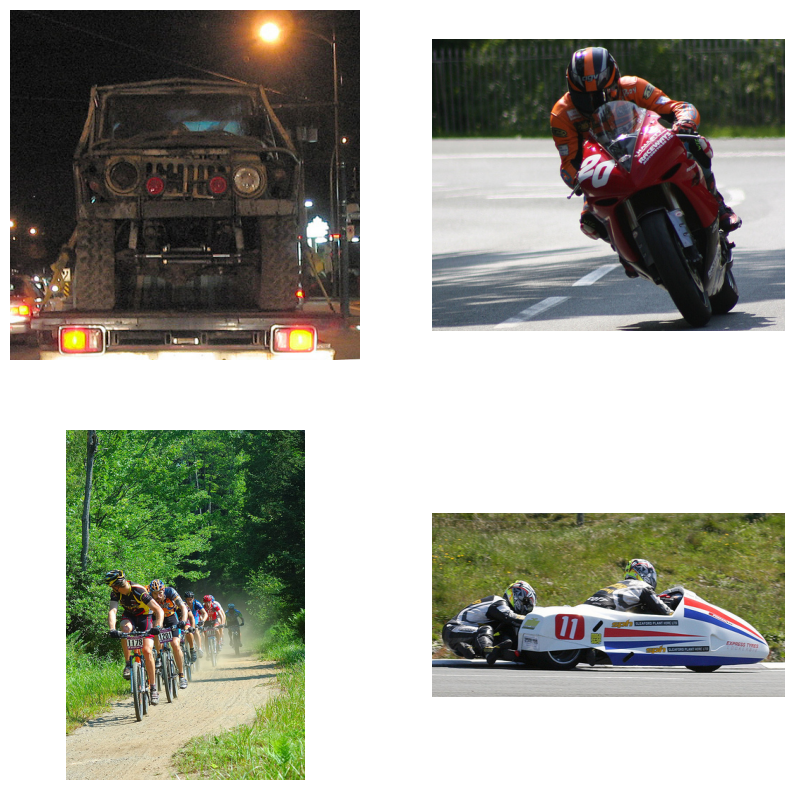

In [80]:
find_match(model, image_embeddings, "race", valid_df["image"].values)

## Опишите свои результаты.

Я описывал выше, резюмирую здесь: в целом прикольно что на локальном авг компе можно запустить и получить +- адекватные результаты модель для работы текст + изображ. Я попробовал запустить ванилку, но очев решил дотюнить до чего то адекватного в рамках своих ресурсов. увеличл кол-во эпох до 30 добавил расписание и аугментацию. Вышло неплохо, расписал выше как можно было бы около гарантировано улучшить качество, но увы у меня нет на такое ресурсов ( hola vsevolod